In [15]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, vit_b_16, ViT_B_16_Weights
from PIL import Image
import pandas as pd

In [17]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.dropna(subset=['diagnosis']).reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.classes = sorted(self.df['diagnosis'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['bcn_filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[row['diagnosis']]
        if self.transform:
            image = self.transform(image)
        return image, label

In [18]:
import torch.nn.functional as F

class CNNtoViT(nn.Module):
    def __init__(self, num_classes=8, cnn_out_channels=1280, dim=768, depth=6, heads=8, mlp_dim=1024):
        super(CNNtoViT, self).__init__()

        # CNN Backbone (EfficientNet B0)
        self.cnn = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.cnn_features = nn.Sequential(*list(self.cnn.children())[:-2])  # Output: (B, 1280, 7, 7)

        # Patch embedding (conv layer to project CNN output to transformer dim)
        self.patch_embed = nn.Conv2d(cnn_out_channels, dim, kernel_size=1)  # Output: (B, 768, 7, 7)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Pool and Classifier
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(dim, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(dim, 256),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(256, num_classes)
        # )

    def forward(self, x):
        x = self.cnn_features(x)           # (B, 1280, 7, 7)
        x = self.patch_embed(x)            # (B, 768, 7, 7)
        x = x.flatten(2).transpose(1, 2)   # (B, 49, 768)
        x = self.transformer(x)            # (B, 49, 768)
        x = x.transpose(1, 2)              # (B, 768, 49)
        x = self.pool(x).squeeze(-1)       # (B, 768)
        return self.classifier(x)


In [19]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, vit_b_16, ViT_B_16_Weights

class ParallelCNNViT(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()

        # CNN Branch: EfficientNet-B0 without classifier
        cnn = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.cnn_branch = nn.Sequential(*list(cnn.children())[:-1])  # Exclude classifier → (B, 1280, 7, 7)

        # Global pooling to get (B, 1280)
        self.cnn_pool = nn.AdaptiveAvgPool2d((1, 1))

        # ViT Branch
        self.vit_branch = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.vit_branch.heads = nn.Identity()  # remove classifier

        # Freeze all layers except last ViT encoder block
        for name, param in self.vit_branch.named_parameters():
            if not any(k in name for k in ['encoder.layers.encoder_layer_11', 'heads']):
                param.requires_grad = False

        # Combined Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1280 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # CNN Feature
        cnn_feat = self.cnn_branch(x)                  # (B, 1280, 7, 7)
        cnn_feat = self.cnn_pool(cnn_feat).squeeze(-1).squeeze(-1)  # (B, 1280)

        # ViT Feature (use CLS token)
        vit_feat = self.vit_branch(x)                  # (B, 768)

        # Combine
        fused = torch.cat([cnn_feat, vit_feat], dim=1) # (B, 2048)

        # Classify
        return self.classifier(fused)


In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, model_name, epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, train_accuracies, val_accuracies = [], [], []
    all_preds, all_labels = [], []
    best_loss = float('inf')  # initialize best loss

    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item() * inputs.size(0)
        train_loss = loss_sum / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_acc = correct / total
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}: Val Acc = {val_acc:.4f}")

        # Save best model weights by loss
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(model.state_dict(), f"/kaggle/working/{model_name}_best_weights.pth")
            print(f"✓ Saved best weights (train loss = {train_loss:.4f})")

    return train_losses, train_accuracies, val_accuracies, all_preds, all_labels

In [21]:
import matplotlib.pyplot as plt

# Assuming you collected accuracy history in these lists during training:
# train_accuracies = [...]
# val_accuracies = [...]

def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
import matplotlib.pyplot as plt

def plot_loss(train_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [24]:
from sklearn.metrics import confusion_matrix

def compute_sens_spec(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    sensitivity = []
    specificity = []

    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)

    for i in range(len(cm)):
        label = class_names[i] if class_names else f"Class {i}"
        print(f"{label}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

In [25]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [26]:
data_dir = '/kaggle/input'

# Training data directory and csv path
train_img_dir = os.path.join(data_dir, 'BCN_20k_train/bcn_20k_train')
train_metadata_path = os.path.join(data_dir, 'bcn_20k_train.csv')

# Testing data directory and csv path
test_img_dir = os.path.join(data_dir, 'BCN_20k_test/bcn_20k_test')
test_metadata_path = os.path.join(data_dir, 'bcn_20k_test.csv')

# Load metadata
metadata = pd.read_csv(train_metadata_path)
print(f"Total training images: {len(metadata)}")
print(f"Total testing images: {len(pd.read_csv(test_metadata_path))}")
metadata.head()

Total training images: 12413
Total testing images: 6533


,bcn_filename,age_approx,anatom_site_general,diagnosis,lesion_id,capture_date,sex,split
0,BCN_0000000001.jpg,55.0,anterior torso,MEL,BCN_0003884,2012-05-16,male,train
1,BCN_0000000003.jpg,50.0,anterior torso,MEL,BCN_0000019,2015-07-09,female,train
2,BCN_0000000004.jpg,85.0,head/neck,SCC,BCN_0003499,2015-11-23,male,train
3,BCN_0000000006.jpg,60.0,anterior torso,NV,BCN_0003316,2015-06-16,male,train
4,BCN_0000000010.jpg,30.0,anterior torso,BCC,BCN_0004874,2014-02-18,female,train


In [27]:
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['diagnosis'], random_state=42)

# Datasets
train_dataset = SkinLesionDataset(train_df, train_img_dir, transform=train_transforms)
val_dataset = SkinLesionDataset(val_df, train_img_dir, transform=val_transforms)

display(train_dataset.classes)
display(train_dataset.class_to_idx)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

In [28]:
# Train CNN → ViT
print("\nTraining CNN to ViT model")
model1 = CNNtoViT(num_classes=len(train_dataset.classes))
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
train_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model1, train_loader, val_loader, criterion, optimizer1, model_name="cnn_to_vit")


Training CNN to ViT model


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 78.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Loss = 1.2098, Train Acc = 0.5678
Epoch 1: Val Acc = 0.6569
✓ Saved best weights (train loss = 1.2098)
Epoch 2: Train Loss = 0.9426, Train Acc = 0.6614
Epoch 2: Val Acc = 0.7008
✓ Saved best weights (train loss = 0.9426)
Epoch 3: Train Loss = 0.7880, Train Acc = 0.7171
Epoch 3: Val Acc = 0.7394
✓ Saved best weights (train loss = 0.7880)
Epoch 4: Train Loss = 0.6857, Train Acc = 0.7571
Epoch 4: Val Acc = 0.7753
✓ Saved best weights (train loss = 0.6857)
Epoch 5: Train Loss = 0.5751, Train Acc = 0.7988
Epoch 5: Val Acc = 0.7668
✓ Saved best weights (train loss = 0.5751)
Epoch 6: Train Loss = 0.5104, Train Acc = 0.8171
Epoch 6: Val Acc = 0.7874
✓ Saved best weights (train loss = 0.5104)
Epoch 7: Train Loss = 0.4306, Train Acc = 0.8456
Epoch 7: Val Acc = 0.7898
✓ Saved best weights (train loss = 0.4306)
Epoch 8: Train Loss = 0.3907, Train Acc = 0.8623
Epoch 8: Val Acc = 0.8035
✓ Saved best weights (train loss = 0.3907)
Epoch 9: Train Loss = 0.3442, Train Acc = 0.8770
Epoch 9

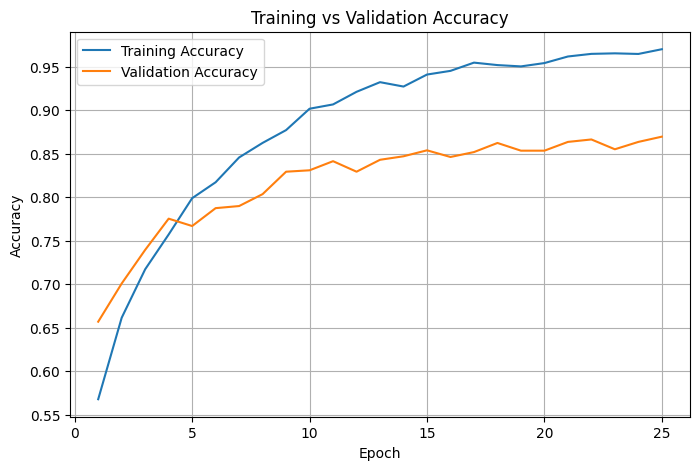

In [29]:
plot_accuracy(train_accuracies, val_accuracies)

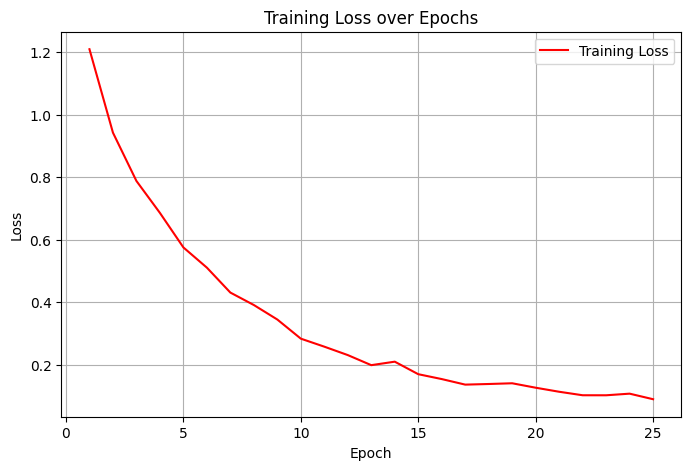

In [30]:
plot_loss(train_losses)

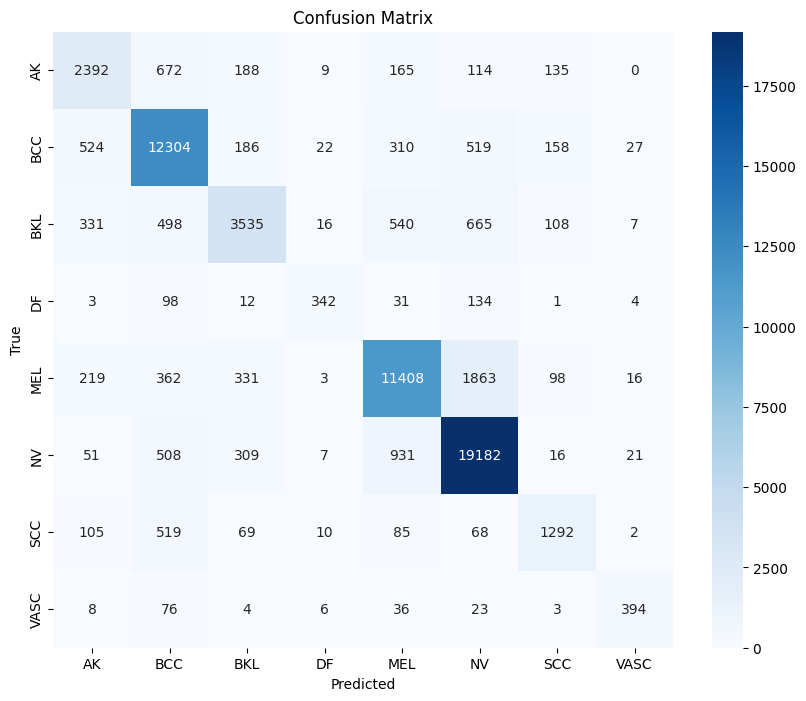

Confusion Matrix:
 [[ 2392   672   188     9   165   114   135     0]
 [  524 12304   186    22   310   519   158    27]
 [  331   498  3535    16   540   665   108     7]
 [    3    98    12   342    31   134     1     4]
 [  219   362   331     3 11408  1863    98    16]
 [   51   508   309     7   931 19182    16    21]
 [  105   519    69    10    85    68  1292     2]
 [    8    76     4     6    36    23     3   394]]
AK: Sensitivity = 0.6509, Specificity = 0.9788
BCC: Sensitivity = 0.8757, Specificity = 0.9431
BKL: Sensitivity = 0.6202, Specificity = 0.9805
DF: Sensitivity = 0.5472, Specificity = 0.9988
MEL: Sensitivity = 0.7978, Specificity = 0.9561
NV: Sensitivity = 0.9123, Specificity = 0.9175
SCC: Sensitivity = 0.6009, Specificity = 0.9913
VASC: Sensitivity = 0.7164, Specificity = 0.9987


In [31]:
# Confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names=train_dataset.classes)

# Sensitivity & Specificity
compute_sens_spec(all_labels, all_preds, class_names=train_dataset.classes)

In [32]:
# from sklearn.metrics import classification_report

# model1.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
#         labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
#         outputs = model1(inputs)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

In [33]:
# Train Parallel CNN + ViT
print("\nTraining Parallel CNN + ViT model")
model2 = ParallelCNNViT(num_classes=len(train_dataset.classes))
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4)
train_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model2, train_loader, val_loader, criterion, optimizer2, model_name="parallel_cnn_vit", epochs=25)


Training Parallel CNN + ViT model


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 206MB/s] 


Epoch 1: Train Loss = 1.1117, Train Acc = 0.6017
Epoch 1: Val Acc = 0.6871
✓ Saved best weights (train loss = 1.1117)
Epoch 2: Train Loss = 0.8358, Train Acc = 0.7005
Epoch 2: Val Acc = 0.7314
✓ Saved best weights (train loss = 0.8358)
Epoch 3: Train Loss = 0.6886, Train Acc = 0.7528
Epoch 3: Val Acc = 0.7600
✓ Saved best weights (train loss = 0.6886)
Epoch 4: Train Loss = 0.5733, Train Acc = 0.7925
Epoch 4: Val Acc = 0.7729
✓ Saved best weights (train loss = 0.5733)
Epoch 5: Train Loss = 0.4627, Train Acc = 0.8363
Epoch 5: Val Acc = 0.7918
✓ Saved best weights (train loss = 0.4627)
Epoch 6: Train Loss = 0.3859, Train Acc = 0.8598
Epoch 6: Val Acc = 0.7922
✓ Saved best weights (train loss = 0.3859)
Epoch 7: Train Loss = 0.3259, Train Acc = 0.8842
Epoch 7: Val Acc = 0.7986
✓ Saved best weights (train loss = 0.3259)
Epoch 8: Train Loss = 0.2594, Train Acc = 0.9053
Epoch 8: Val Acc = 0.8220
✓ Saved best weights (train loss = 0.2594)
Epoch 9: Train Loss = 0.2220, Train Acc = 0.9196
Epoch 9

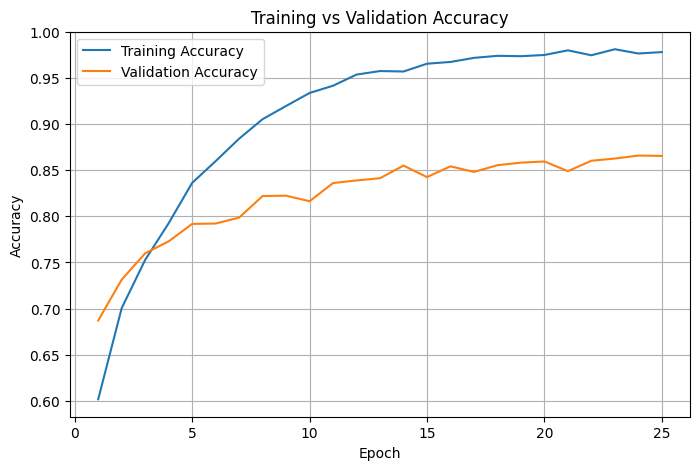

In [34]:
plot_accuracy(train_accuracies, val_accuracies)

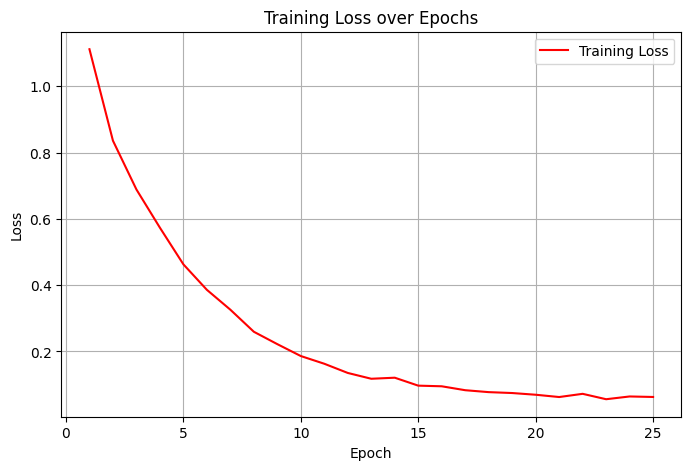

In [35]:
plot_loss(train_losses)

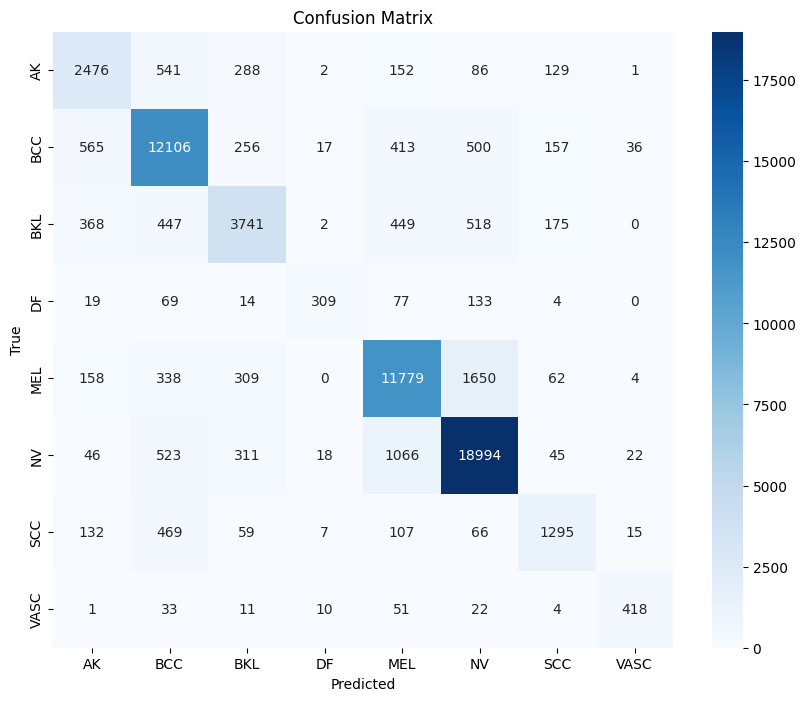

Confusion Matrix:
 [[ 2476   541   288     2   152    86   129     1]
 [  565 12106   256    17   413   500   157    36]
 [  368   447  3741     2   449   518   175     0]
 [   19    69    14   309    77   133     4     0]
 [  158   338   309     0 11779  1650    62     4]
 [   46   523   311    18  1066 18994    45    22]
 [  132   469    59     7   107    66  1295    15]
 [    1    33    11    10    51    22     4   418]]
AK: Sensitivity = 0.6737, Specificity = 0.9779
BCC: Sensitivity = 0.8616, Specificity = 0.9496
BKL: Sensitivity = 0.6563, Specificity = 0.9779
DF: Sensitivity = 0.4944, Specificity = 0.9991
MEL: Sensitivity = 0.8237, Specificity = 0.9515
NV: Sensitivity = 0.9034, Specificity = 0.9275
SCC: Sensitivity = 0.6023, Specificity = 0.9904
VASC: Sensitivity = 0.7600, Specificity = 0.9987


In [36]:
# Confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names=train_dataset.classes)

# Sensitivity & Specificity
compute_sens_spec(all_labels, all_preds, class_names=train_dataset.classes)

In [37]:
# from sklearn.metrics import classification_report

# model2.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
#         labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
#         outputs = model2(inputs)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))